<a href="https://colab.research.google.com/github/helainytorres/RedesNeurais/blob/main/lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
colab = True 

import os 

if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 2')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 318 (delta 123), reused 238 (delta 47), pack-reused 0
Receiving objects: 100% (318/318), 3.98 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (123/123), done.


# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante: Helainy Torres

Base de dados: Microclima3

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm


## Preparação para a lista

In [4]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [5]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y


In [6]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [7]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary': # Como são 12 meses a representação pode ser feita com 4 bits 
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
      
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
        #print('Cheguei aqui também')
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [8]:
dataset_name = 'microclima3'
path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)


## Parte I - Compreensão do problema

Total: 3,0 pts.

#### 1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

In [ ]:
raw_data

,value,time
0,39.277880,1.0
1,39.758673,2.0
2,37.317972,3.0
3,33.607143,4.0
4,27.605530,5.0
...,...,...
139,27.384332,8.0
140,30.956190,9.0
141,29.165438,10.0
142,37.649048,11.0


In [ ]:
x=raw_data['time']
y=raw_data['value']

In [ ]:
media=raw_data.rolling(12).mean() #média móvel
ym = media['value']
desvio = raw_data.rolling(12).std() # desvio padrao
dp = desvio['value']


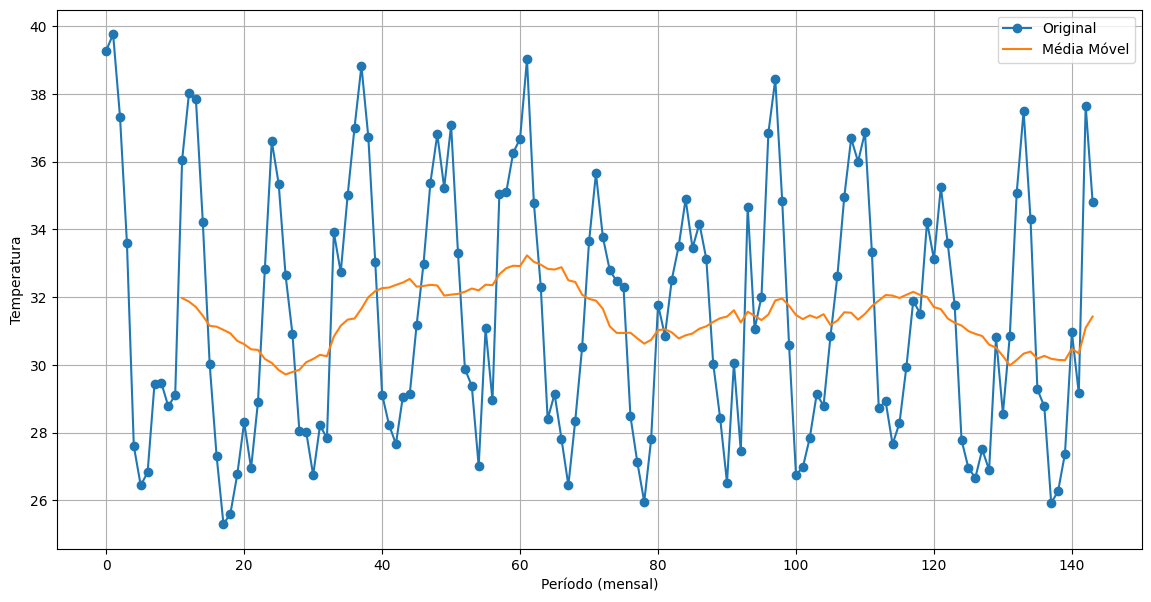

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(y, marker='o')
plt.plot(ym)
plt.legend(['Original','Média Móvel'])
plt.xlabel('Período (mensal)')
plt.ylabel('Temperatura')
plt.grid(True)
plt.show()

No gráfico acima, além da série em azul, temos a média móvel em laranja, a média móvel é uma forma alternativa para analisar a tendência de uma série temporal. Neste caso, calculou-se a média dos 12 períodos anteriores.

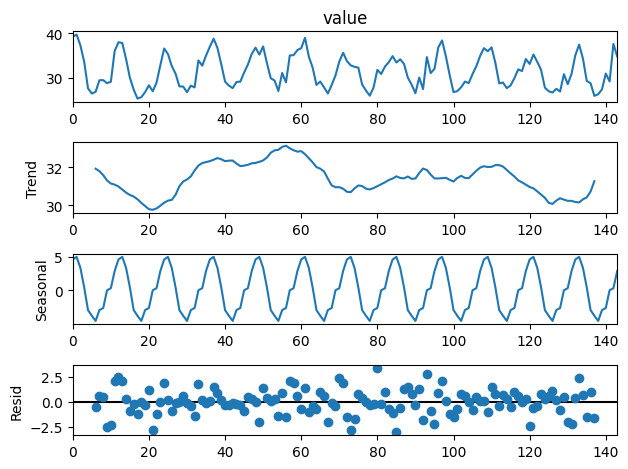

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y, model='additive',period=12)
result.plot()
plt.show()

A decomposição de séries temporais, envolve pensar que uma série pode ser descrita como a soma de um nível, sazonalidade e ruído. Serve para tentar descrever melhor seu comportamento e a compreenção geral do problema durante a análise.
Uma série temporal pode ser descrita como a soma de valores de uma tendência, sazonalidade e resíduos.
            
            V = T + S + R

A análise de decomposição sazonal, período igual a 12,  as informações de tendência e sazonalidade extraídas da série mostraram comportamento  razoáveis.

Análise de desvio padrão

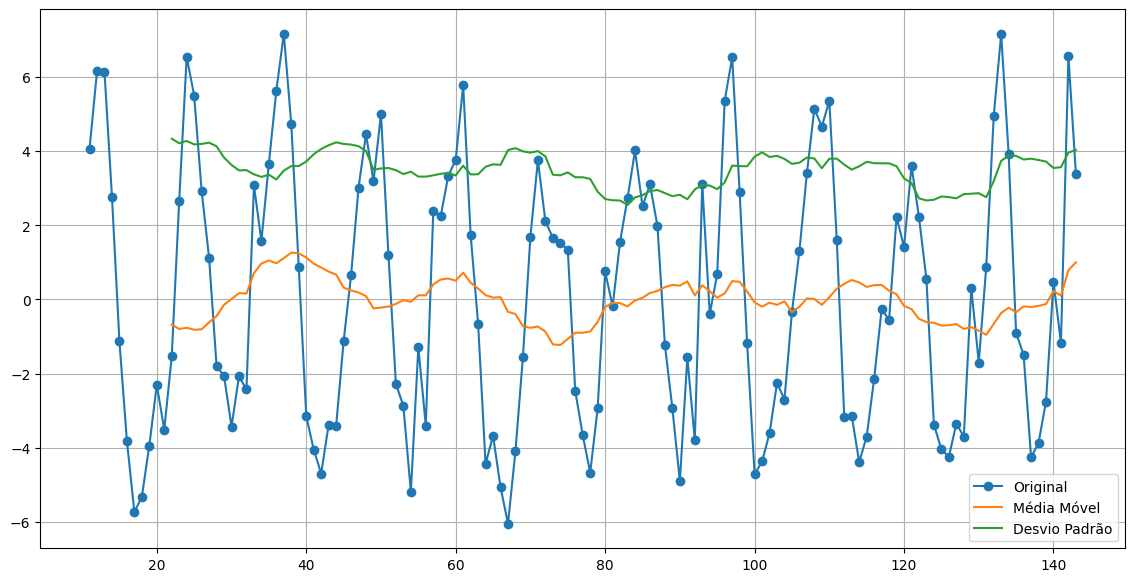

In [ ]:
d = y-ym

plt.figure(figsize=(14,7))
plt.plot(d, marker='o')
plt.plot(d.rolling(12).mean())
plt.plot(d.rolling(12).std())
plt.legend(['Original','Média Móvel', 'Desvio Padrão'])
plt.grid(True)
plt.show()

Após todas as análises, podemos concluir que a série se tornou adequada para a resolução do modelo de serie temporal já que foi identificado um padrão para os dados.

#### 2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

A variável endógena é a informação original do dado, já na variável exógena existe uma informação implícita que pode auxiliar na modelagem, . 

No caso da temporalidade, o período pode explicar a recorrência na variações de informação, sazonalidade.



No caso de um problema climático, a variável exogena auxilia na criação da previsão temporal natural dos períodos do ano, assim conseguimos observar a tendencia dos dados e gerar o comportamento de acordo com o periodo de tempo especificado que pode melhorar a precisão.


#### 3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.

1. Dividir os dados que serão usados no treinamento e teste.
  
2. Normalizar os dados, ajuste de mímimo e máximo.

3. Transformação do dados em sequência de 12, pela sazonalidade implicita do tempo. 




## Parte 2 - Previsão one-step

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula. 
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### 1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

In [ ]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')
# Inicialização de dados
# Divisão em treino e teste
# Criação de sequencias de periodo 12



In [ ]:
train_val # Visualização de dados de treino

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [ ]:
test_val # Visualização de dados de teste

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [ ]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [ ]:
#Crianção de dataset de entrada

train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [ ]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
# Parametros da Rede
n_input = X_train.shape[1] # Neurônios de entrada
n_output = 1  # Neurônio de saída
hidden_neurons = 20  # Camada interna

In [ ]:
# Criando o modelo de rede
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05  #taxa de aprendizado
epochs = 1000  #épocas

#Treinamento da rede
history, y_hat = train(model, train_loader, epochs, device, lr)

 10%|█         | 102/1000 [00:00<00:02, 381.41it/s]

Epoch 51/1000, Loss: 0.0311
Epoch 101/1000, Loss: 0.0180


 24%|██▎       | 236/1000 [00:00<00:01, 431.95it/s]

Epoch 151/1000, Loss: 0.0123
Epoch 201/1000, Loss: 0.0111


 32%|███▏      | 324/1000 [00:00<00:01, 434.95it/s]

Epoch 251/1000, Loss: 0.0108
Epoch 301/1000, Loss: 0.0106


 42%|████▏     | 418/1000 [00:01<00:01, 452.64it/s]

Epoch 351/1000, Loss: 0.0104
Epoch 401/1000, Loss: 0.0103


 51%|█████     | 510/1000 [00:01<00:01, 452.43it/s]

Epoch 451/1000, Loss: 0.0102
Epoch 501/1000, Loss: 0.0101


 60%|██████    | 601/1000 [00:01<00:00, 441.64it/s]

Epoch 551/1000, Loss: 0.0100
Epoch 601/1000, Loss: 0.0099


 74%|███████▍  | 741/1000 [00:01<00:00, 455.21it/s]

Epoch 651/1000, Loss: 0.0098
Epoch 701/1000, Loss: 0.0097


 84%|████████▎ | 837/1000 [00:01<00:00, 466.18it/s]

Epoch 751/1000, Loss: 0.0097
Epoch 801/1000, Loss: 0.0096


 93%|█████████▎| 931/1000 [00:02<00:00, 465.26it/s]

Epoch 851/1000, Loss: 0.0095
Epoch 901/1000, Loss: 0.0095


100%|██████████| 1000/1000 [00:02<00:00, 437.30it/s]

Epoch 951/1000, Loss: 0.0094
Epoch 1001/1000, Loss: 0.0094


In [ ]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


In [ ]:
from sklearn.metrics import r2_score

Erro MSE = 6.464 
Erro MAE = 1.874  
R2 Score = 0.61 


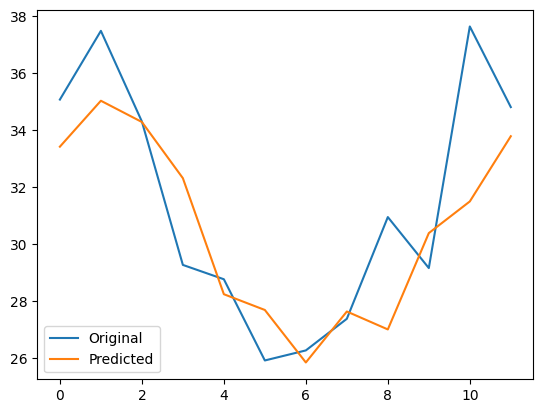

In [ ]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min

mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)  #(Mean Absoluto Error)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)   #(Mean Squared Error)
r2_error = r2_score(orig_y_eval, orig_y_hat)              #(R dois score)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}  \nR2 Score = {round(r2_error,3)} ')



Quanto maior o valor de R2 score, mais explicativo será o modelo em relação aos pevistos, no caso R2 foi 61%. De acordo com o valor calculado do MAE, os valores previstos podem varias de 1,87°. Já que a diferença entre MSE e MAE não é muito grande, podemos concluir que não há um grande número de outlier. MSE, por ser quadrático pode aumentar o erro e penalizar todo o modelo quando existem outliers.


In [ ]:
mae_error

1.8740759104704345

In [ ]:
mse_error

6.464240095266233

#### 2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

Na função transform_data, foi implementado a segmentacao dos dados para o formato numerico 

In [ ]:
prev = 12
lg = 12

In [ ]:
# Divisão em treino e teste
train_val_real ,test_val_real = transform_data(raw_data,lag=lg,test_split = prev,normalize=True,category='real')


In [ ]:
train_val_real

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [ ]:
test_val_real

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


Na codificação binária, podiamos observar que os valores de saída eram representados com 4 bits , quatro colunas. Aqui, somente uma coluna é utilizada para representar a temporalidade e não tem mais a sazonalidade que a variavél exogena permitia. A rede provavelmente não vai comparar os períodos de forma adequada.

In [ ]:
train_values = train_val_real.values

X_train_real = train_values[:,:-1]
y_train_real = train_values[:,-1]

test_values = test_val_real.values
X_test_real = test_values[:,:-1]
y_test_real = test_values[:,-1]

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train_real).float(), torch.from_numpy(y_train_real).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test_real).float(), torch.from_numpy(y_test_real).float().unsqueeze(1))

In [ ]:
n_input = X_train_real.shape[1]
n_output = 1
hidden_neurons = 20

In [ ]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

 11%|█         | 106/1000 [00:00<00:03, 284.03it/s]

Epoch 51/1000, Loss: 0.0254
Epoch 101/1000, Loss: 0.0161


 20%|██        | 205/1000 [00:00<00:02, 308.24it/s]

Epoch 151/1000, Loss: 0.0137
Epoch 201/1000, Loss: 0.0135


 30%|███       | 301/1000 [00:01<00:02, 312.80it/s]

Epoch 251/1000, Loss: 0.0135
Epoch 301/1000, Loss: 0.0135


 40%|███▉      | 399/1000 [00:01<00:01, 302.57it/s]

Epoch 351/1000, Loss: 0.0135
Epoch 401/1000, Loss: 0.0134


 50%|████▉     | 498/1000 [00:01<00:01, 315.65it/s]

Epoch 451/1000, Loss: 0.0133
Epoch 501/1000, Loss: 0.0132


 60%|██████    | 601/1000 [00:01<00:01, 329.20it/s]

Epoch 551/1000, Loss: 0.0131
Epoch 601/1000, Loss: 0.0130


 70%|███████   | 701/1000 [00:02<00:00, 331.08it/s]

Epoch 651/1000, Loss: 0.0129
Epoch 701/1000, Loss: 0.0128


 80%|████████  | 801/1000 [00:02<00:00, 320.59it/s]

Epoch 751/1000, Loss: 0.0127
Epoch 801/1000, Loss: 0.0126


 90%|█████████ | 903/1000 [00:02<00:00, 328.32it/s]

Epoch 851/1000, Loss: 0.0125
Epoch 901/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:03<00:00, 314.10it/s]

Epoch 951/1000, Loss: 0.0124
Epoch 1001/1000, Loss: 0.0123


In [ ]:
y_pred = model(torch.from_numpy(X_test_real).float())
y_hat = y_pred.detach().numpy()

In [ ]:
from sklearn.metrics import r2_score

Erro MSE = 6.586 
Erro MAE = 1.79  
R2 Score = 0.603 


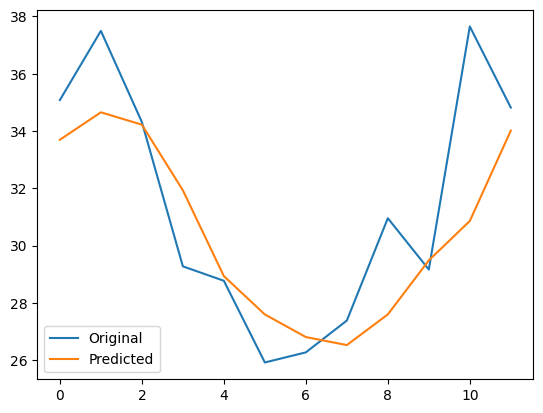

In [ ]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min

mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)  #(Mean Absoluto Error)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)   #(Mean Squared Error)
r2_error = r2_score(orig_y_eval, orig_y_hat)              #(R dois score)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}  \nR2 Score = {round(r2_error,3)} ')

Quanto maior o valor de R2 score, mais explicativo será o modelo em relação aos pevistos, no caso R2 foi 60%. De acordo com o valor calculado do MAE, os valores previstos podem varias de 1,79°. Já que a diferença entre MSE e MAE não é muito grande, podemos concluir que não há um grande número de outlier. MSE, por ser quadrático pode aumentar o erro e penalizar todo o modelo quando existem outliers.

## Parte 3 - Previsão multi-step

Total: 5,0 pts.

#### 1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 



1.   Definir o tamanho do passo a ser previsto
2.   Ajustar o modelo para aquantidade de passos definidas
3.   Treinameto do modelo
4.   Predição e análise de erros



In [ ]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

#### 2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

In [26]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')

In [27]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [28]:
X_test.shape

(12, 14)

In [29]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [30]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')

In [31]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [32]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [33]:
prev = 12 # Tamanho da janela a ser gerada

In [34]:
train(model, train_loader, epochs, device, lr)
y_result = multi_step(model, X_test, cod='numeric')

  9%|▉         | 91/1000 [00:00<00:03, 301.49it/s]

Epoch 51/1000, Loss: 0.0484
Epoch 101/1000, Loss: 0.0465


 18%|█▊        | 184/1000 [00:00<00:02, 302.45it/s]

Epoch 151/1000, Loss: 0.0446
Epoch 201/1000, Loss: 0.0429


 31%|███       | 306/1000 [00:01<00:02, 296.10it/s]

Epoch 251/1000, Loss: 0.0413
Epoch 301/1000, Loss: 0.0397


 40%|███▉      | 397/1000 [00:01<00:02, 300.19it/s]

Epoch 351/1000, Loss: 0.0381
Epoch 401/1000, Loss: 0.0366


 49%|████▉     | 492/1000 [00:01<00:01, 306.45it/s]

Epoch 451/1000, Loss: 0.0351
Epoch 501/1000, Loss: 0.0337


 59%|█████▊    | 586/1000 [00:01<00:01, 305.87it/s]

Epoch 551/1000, Loss: 0.0322
Epoch 601/1000, Loss: 0.0308


 71%|███████   | 710/1000 [00:02<00:00, 302.87it/s]

Epoch 651/1000, Loss: 0.0295
Epoch 701/1000, Loss: 0.0282


 81%|████████  | 806/1000 [00:02<00:00, 311.96it/s]

Epoch 751/1000, Loss: 0.0269
Epoch 801/1000, Loss: 0.0256


 90%|█████████ | 901/1000 [00:02<00:00, 301.31it/s]

Epoch 851/1000, Loss: 0.0244
Epoch 901/1000, Loss: 0.0233


100%|██████████| 1000/1000 [00:03<00:00, 301.17it/s]

Epoch 951/1000, Loss: 0.0223
Epoch 1001/1000, Loss: 0.0213


In [35]:
y_result  #Passos previstos

array([0.55180216, 0.5561973 , 0.51177526, 0.4781722 , 0.40326598,
       0.37061146, 0.35015234, 0.33520165, 0.33284655, 0.3599291 ,
       0.37621233, 0.41029194], dtype=float32)

In [36]:
y_test

array([0.67661474, 0.84349753, 0.62336684, 0.27514706, 0.24033889,
       0.04313579, 0.06753019, 0.14432697, 0.39131733, 0.26748862,
       0.85412154, 0.65835559])

Erro MSE = 12.266 
Erro MAE = 3.094 


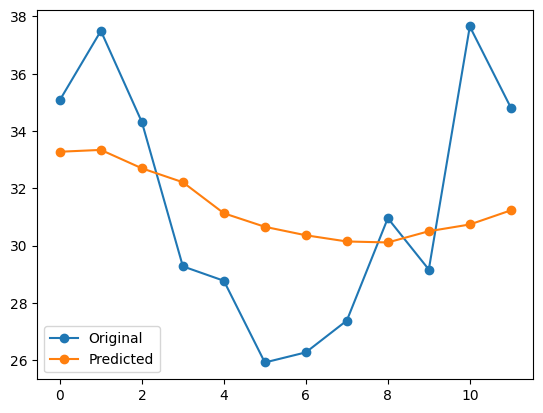

In [39]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min

mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)  #(Mean Absoluto Error)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)   #(Mean Squared Error)

plt.plot(orig_y_eval,marker='o')
plt.plot(orig_y_hat,marker='o')
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)} ')

O erro no modelo multi step é maior do que no one step. E como cada passo dependerá dos anteriores, no multi step esse erro se propagará e aumentará com o passar do tempo sendo assim injusta a comparação com o modelo one step.

#### 3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

In [54]:
#Definindo uma função que permita uma variação notamanho da janela de entrada

def multi_step_window(model, window,X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por window (para que o mês fique sempre entre 0 e window-1)
        tmp = int(X_t[0] * window + 1) % window
        
        #Alterando a variável mês
        X_t[0] = tmp/window
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [56]:
def multistep (window):
    prev = window   #Janela de treinamento

    #Dividindo dados de treinamento e teste
    train_val ,test_val = transform_data(raw_data,lag=window,test_split = prev,normalize=True,category='numeric')

    train_values = train_val.values
    X_train = train_values[:,:-1]
    y_train = train_values[:,-1]
    
    test_values = test_val.values
    X_test = test_values[:,:-1]
    y_test = test_values[:,-1]
    
    #Inicializndo parâmetros da redes
    n_input = X_train.shape[1]    #in
    n_output = 1                  #out
    hidden_neurons = 20           #hidden

    #Gerando modelo
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    
    batch_size = 32
    
    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    
    train(model, train_loader, epochs, device, lr)
    y_result = multi_step_window(model, window, X_test, cod='numeric')
    
    return y_result

In [61]:
window = [2,3,4,6,9,11,12,15,18,21,24,27,30,36,48]

mae_error = []
mse_error = []

orig_y_eval = []
orig_y_hat = []

for x in range(0,len(window)):
   y_result = multistep(window[x])
   orig_y_eval = y_test*(_max-_min) + _min
   orig_y_hat = y_result*(_max-_min) + _min
   mae_error.append(mean_absolute_error(orig_y_eval, orig_y_hat))
   mse_error.append(mean_squared_error(orig_y_eval, orig_y_hat))

resultado = dict(window = window,
                   mae_error = mae_error,
                   mse_error = mse_error)
resultado_df = pd.DataFrame(data=resultado)

  8%|▊         | 75/1000 [00:00<00:08, 105.00it/s]

Epoch 51/1000, Loss: 0.0614


 14%|█▍        | 141/1000 [00:01<00:04, 181.71it/s]

Epoch 101/1000, Loss: 0.0583


 19%|█▉        | 189/1000 [00:01<00:03, 206.94it/s]

Epoch 151/1000, Loss: 0.0555


 24%|██▍       | 239/1000 [00:01<00:03, 228.62it/s]

Epoch 201/1000, Loss: 0.0531
Epoch 251/1000, Loss: 0.0509


 34%|███▍      | 338/1000 [00:02<00:02, 238.86it/s]

Epoch 301/1000, Loss: 0.0489


 38%|███▊      | 385/1000 [00:02<00:02, 226.38it/s]

Epoch 351/1000, Loss: 0.0470


 43%|████▎     | 434/1000 [00:02<00:02, 232.41it/s]

Epoch 401/1000, Loss: 0.0453


 48%|████▊     | 483/1000 [00:02<00:02, 234.85it/s]

Epoch 451/1000, Loss: 0.0436


 53%|█████▎    | 532/1000 [00:02<00:01, 238.60it/s]

Epoch 501/1000, Loss: 0.0421


 58%|█████▊    | 580/1000 [00:03<00:01, 235.07it/s]

Epoch 551/1000, Loss: 0.0407


 63%|██████▎   | 630/1000 [00:03<00:01, 233.54it/s]

Epoch 601/1000, Loss: 0.0393


 68%|██████▊   | 680/1000 [00:03<00:01, 239.11it/s]

Epoch 651/1000, Loss: 0.0380
Epoch 701/1000, Loss: 0.0367

 73%|███████▎  | 731/1000 [00:03<00:01, 238.98it/s]

 78%|███████▊  | 780/1000 [00:03<00:00, 239.26it/s]

Epoch 751/1000, Loss: 0.0355
Epoch 801/1000, Loss: 0.0344


 88%|████████▊ | 879/1000 [00:04<00:00, 233.31it/s]

Epoch 851/1000, Loss: 0.0333


 93%|█████████▎| 928/1000 [00:04<00:00, 234.63it/s]

Epoch 901/1000, Loss: 0.0323


 98%|█████████▊| 977/1000 [00:04<00:00, 230.86it/s]

Epoch 951/1000, Loss: 0.0313


100%|██████████| 1000/1000 [00:04<00:00, 206.49it/s]


Epoch 1001/1000, Loss: 0.0304


  8%|▊         | 75/1000 [00:00<00:03, 241.43it/s]

Epoch 51/1000, Loss: 0.0785
Epoch 101/1000, Loss: 0.0752

 13%|█▎        | 126/1000 [00:00<00:03, 241.65it/s]

 18%|█▊        | 177/1000 [00:00<00:03, 245.93it/s]

Epoch 151/1000, Loss: 0.0722
Epoch 201/1000, Loss: 0.0693

 23%|██▎       | 228/1000 [00:00<00:03, 244.95it/s]

 28%|██▊       | 277/1000 [00:01<00:03, 239.61it/s]

Epoch 251/1000, Loss: 0.0666


 33%|███▎      | 327/1000 [00:01<00:02, 238.85it/s]

Epoch 301/1000, Loss: 0.0639


 38%|███▊      | 377/1000 [00:01<00:02, 243.33it/s]

Epoch 351/1000, Loss: 0.0613
Epoch 401/1000, Loss: 0.0587


 48%|████▊     | 480/1000 [00:01<00:02, 248.48it/s]

Epoch 451/1000, Loss: 0.0561
Epoch 501/1000, Loss: 0.0536


 58%|█████▊    | 581/1000 [00:02<00:01, 242.33it/s]

Epoch 551/1000, Loss: 0.0511


 63%|██████▎   | 631/1000 [00:02<00:01, 240.41it/s]

Epoch 601/1000, Loss: 0.0486
Epoch 651/1000, Loss: 0.0463

 68%|██████▊   | 683/1000 [00:02<00:01, 249.15it/s]


Epoch 701/1000, Loss: 0.0439


 79%|███████▊  | 787/1000 [00:03<00:00, 246.93it/s]

Epoch 751/1000, Loss: 0.0417


 84%|████████▎ | 837/1000 [00:03<00:00, 235.29it/s]

Epoch 801/1000, Loss: 0.0396


 89%|████████▊ | 887/1000 [00:03<00:00, 237.43it/s]

Epoch 851/1000, Loss: 0.0376
Epoch 901/1000, Loss: 0.0358

 94%|█████████▎| 937/1000 [00:03<00:00, 240.64it/s]

 99%|█████████▊| 987/1000 [00:04<00:00, 240.08it/s]

Epoch 951/1000, Loss: 0.0341


100%|██████████| 1000/1000 [00:04<00:00, 242.11it/s]


Epoch 1001/1000, Loss: 0.0325


  8%|▊         | 78/1000 [00:00<00:03, 235.57it/s]

Epoch 51/1000, Loss: 0.0774


 13%|█▎        | 128/1000 [00:00<00:03, 235.75it/s]

Epoch 101/1000, Loss: 0.0739


 18%|█▊        | 178/1000 [00:00<00:03, 242.71it/s]

Epoch 151/1000, Loss: 0.0705


 23%|██▎       | 229/1000 [00:00<00:03, 244.47it/s]

Epoch 201/1000, Loss: 0.0669
Epoch 251/1000, Loss: 0.0633


 33%|███▎      | 333/1000 [00:01<00:02, 244.86it/s]

Epoch 301/1000, Loss: 0.0597


 38%|███▊      | 384/1000 [00:01<00:02, 240.61it/s]

Epoch 351/1000, Loss: 0.0560
Epoch 401/1000, Loss: 0.0524


 49%|████▊     | 486/1000 [00:02<00:02, 220.31it/s]

Epoch 451/1000, Loss: 0.0488


 53%|█████▎    | 530/1000 [00:02<00:02, 191.12it/s]

Epoch 501/1000, Loss: 0.0454


 57%|█████▋    | 569/1000 [00:02<00:02, 179.30it/s]

Epoch 551/1000, Loss: 0.0423


 62%|██████▎   | 625/1000 [00:02<00:02, 178.21it/s]

Epoch 601/1000, Loss: 0.0393


 68%|██████▊   | 680/1000 [00:03<00:01, 177.26it/s]

Epoch 651/1000, Loss: 0.0367


 72%|███████▏  | 716/1000 [00:03<00:01, 175.80it/s]

Epoch 701/1000, Loss: 0.0344


 77%|███████▋  | 772/1000 [00:03<00:01, 177.85it/s]

Epoch 751/1000, Loss: 0.0324


 83%|████████▎ | 826/1000 [00:04<00:01, 171.78it/s]

Epoch 801/1000, Loss: 0.0306


 88%|████████▊ | 881/1000 [00:04<00:00, 178.10it/s]

Epoch 851/1000, Loss: 0.0292


 93%|█████████▎| 934/1000 [00:04<00:00, 166.95it/s]

Epoch 901/1000, Loss: 0.0280


 97%|█████████▋| 968/1000 [00:04<00:00, 163.67it/s]

Epoch 951/1000, Loss: 0.0270


100%|██████████| 1000/1000 [00:05<00:00, 198.45it/s]


Epoch 1001/1000, Loss: 0.0262


  8%|▊         | 80/1000 [00:00<00:03, 253.26it/s]

Epoch 51/1000, Loss: 0.0505


 13%|█▎        | 131/1000 [00:00<00:03, 242.37it/s]

Epoch 101/1000, Loss: 0.0487


 18%|█▊        | 182/1000 [00:00<00:03, 241.69it/s]

Epoch 151/1000, Loss: 0.0470
Epoch 201/1000, Loss: 0.0455


 29%|██▉       | 288/1000 [00:01<00:02, 255.15it/s]

Epoch 251/1000, Loss: 0.0441
Epoch 301/1000, Loss: 0.0429


 39%|███▉      | 392/1000 [00:01<00:02, 240.76it/s]

Epoch 351/1000, Loss: 0.0418


 44%|████▍     | 443/1000 [00:01<00:02, 244.02it/s]

Epoch 401/1000, Loss: 0.0409


 49%|████▉     | 494/1000 [00:02<00:02, 245.89it/s]

Epoch 451/1000, Loss: 0.0401
Epoch 501/1000, Loss: 0.0394


 57%|█████▋    | 572/1000 [00:02<00:01, 252.57it/s]

Epoch 551/1000, Loss: 0.0388


 65%|██████▍   | 649/1000 [00:02<00:01, 245.28it/s]

Epoch 601/1000, Loss: 0.0383
Epoch 651/1000, Loss: 0.0378


 73%|███████▎  | 726/1000 [00:02<00:01, 250.02it/s]

Epoch 701/1000, Loss: 0.0375
Epoch 751/1000, Loss: 0.0371


 83%|████████▎ | 831/1000 [00:03<00:00, 253.05it/s]

Epoch 801/1000, Loss: 0.0368


 88%|████████▊ | 882/1000 [00:03<00:00, 243.59it/s]

Epoch 851/1000, Loss: 0.0365


 93%|█████████▎| 932/1000 [00:03<00:00, 245.87it/s]

Epoch 901/1000, Loss: 0.0362
Epoch 951/1000, Loss: 0.0358


100%|██████████| 1000/1000 [00:04<00:00, 247.11it/s]


Epoch 1001/1000, Loss: 0.0355


  3%|▎         | 30/1000 [00:00<00:03, 299.85it/s]

Epoch 51/1000, Loss: 0.0468


  9%|▉         | 91/1000 [00:00<00:03, 300.51it/s]

Epoch 101/1000, Loss: 0.0439


 15%|█▌        | 152/1000 [00:00<00:03, 273.53it/s]

Epoch 151/1000, Loss: 0.0410


 18%|█▊        | 181/1000 [00:00<00:02, 277.77it/s]

Epoch 201/1000, Loss: 0.0382


 24%|██▍       | 241/1000 [00:00<00:02, 285.75it/s]

Epoch 251/1000, Loss: 0.0355


 30%|███       | 302/1000 [00:01<00:02, 293.95it/s]

Epoch 301/1000, Loss: 0.0328


 33%|███▎      | 332/1000 [00:01<00:02, 293.75it/s]

Epoch 351/1000, Loss: 0.0302


 39%|███▉      | 392/1000 [00:01<00:02, 288.92it/s]

Epoch 401/1000, Loss: 0.0278


 45%|████▌     | 452/1000 [00:01<00:01, 289.59it/s]

Epoch 451/1000, Loss: 0.0256


 48%|████▊     | 482/1000 [00:01<00:01, 288.95it/s]

Epoch 501/1000, Loss: 0.0236


 54%|█████▍    | 543/1000 [00:01<00:01, 293.73it/s]

Epoch 551/1000, Loss: 0.0218


 60%|██████    | 605/1000 [00:02<00:01, 299.16it/s]

Epoch 601/1000, Loss: 0.0202


 64%|██████▎   | 635/1000 [00:02<00:01, 296.55it/s]

Epoch 651/1000, Loss: 0.0189


 70%|██████▉   | 697/1000 [00:02<00:01, 293.65it/s]

Epoch 701/1000, Loss: 0.0177


 73%|███████▎  | 727/1000 [00:02<00:00, 279.86it/s]

Epoch 751/1000, Loss: 0.0168


 79%|███████▊  | 787/1000 [00:02<00:00, 288.98it/s]

Epoch 801/1000, Loss: 0.0160


 85%|████████▍ | 848/1000 [00:02<00:00, 293.92it/s]

Epoch 851/1000, Loss: 0.0154


 91%|█████████ | 907/1000 [00:03<00:00, 288.22it/s]

Epoch 901/1000, Loss: 0.0149


 94%|█████████▎| 936/1000 [00:03<00:00, 286.73it/s]

Epoch 951/1000, Loss: 0.0145


100%|██████████| 1000/1000 [00:03<00:00, 286.42it/s]

Epoch 1001/1000, Loss: 0.0142



  3%|▎         | 32/1000 [00:00<00:03, 312.75it/s]

Epoch 51/1000, Loss: 0.0477


 10%|▉         | 96/1000 [00:00<00:02, 307.18it/s]

Epoch 101/1000, Loss: 0.0435


 16%|█▌        | 158/1000 [00:00<00:02, 303.31it/s]

Epoch 151/1000, Loss: 0.0395


 19%|█▉        | 189/1000 [00:00<00:02, 299.75it/s]

Epoch 201/1000, Loss: 0.0357


 25%|██▍       | 249/1000 [00:00<00:02, 289.28it/s]

Epoch 251/1000, Loss: 0.0321


 28%|██▊       | 279/1000 [00:00<00:02, 291.28it/s]

Epoch 301/1000, Loss: 0.0287


 34%|███▍      | 338/1000 [00:01<00:02, 283.71it/s]

Epoch 351/1000, Loss: 0.0256


 40%|███▉      | 397/1000 [00:01<00:02, 285.22it/s]

Epoch 401/1000, Loss: 0.0229


 46%|████▌     | 455/1000 [00:01<00:01, 283.29it/s]

Epoch 451/1000, Loss: 0.0206


 48%|████▊     | 484/1000 [00:01<00:01, 281.98it/s]

Epoch 501/1000, Loss: 0.0186


 54%|█████▍    | 544/1000 [00:01<00:01, 282.37it/s]

Epoch 551/1000, Loss: 0.0171


 60%|██████    | 602/1000 [00:02<00:01, 274.60it/s]

Epoch 601/1000, Loss: 0.0159


 63%|██████▎   | 631/1000 [00:02<00:01, 278.73it/s]

Epoch 651/1000, Loss: 0.0150


 74%|███████▍  | 743/1000 [00:02<00:01, 238.98it/s]

Epoch 701/1000, Loss: 0.0143


 77%|███████▋  | 768/1000 [00:02<00:01, 226.31it/s]

Epoch 751/1000, Loss: 0.0138


 84%|████████▎ | 835/1000 [00:03<00:00, 208.77it/s]

Epoch 801/1000, Loss: 0.0135


 88%|████████▊ | 878/1000 [00:03<00:00, 205.92it/s]

Epoch 851/1000, Loss: 0.0132


 94%|█████████▍| 942/1000 [00:03<00:00, 206.41it/s]

Epoch 901/1000, Loss: 0.0131


 98%|█████████▊| 984/1000 [00:03<00:00, 203.23it/s]

Epoch 951/1000, Loss: 0.0129


100%|██████████| 1000/1000 [00:03<00:00, 252.44it/s]


Epoch 1001/1000, Loss: 0.0128


  8%|▊         | 85/1000 [00:00<00:04, 209.91it/s]

Epoch 51/1000, Loss: 0.0418


 13%|█▎        | 128/1000 [00:00<00:04, 211.14it/s]

Epoch 101/1000, Loss: 0.0378


 17%|█▋        | 172/1000 [00:00<00:03, 211.38it/s]

Epoch 151/1000, Loss: 0.0341


 24%|██▎       | 236/1000 [00:01<00:03, 204.67it/s]

Epoch 201/1000, Loss: 0.0306


 28%|██▊       | 278/1000 [00:01<00:03, 200.63it/s]

Epoch 251/1000, Loss: 0.0273


 36%|███▌      | 359/1000 [00:01<00:02, 247.99it/s]

Epoch 301/1000, Loss: 0.0243
Epoch 351/1000, Loss: 0.0217


 45%|████▍     | 449/1000 [00:01<00:01, 277.26it/s]

Epoch 401/1000, Loss: 0.0194
Epoch 451/1000, Loss: 0.0175


 54%|█████▍    | 541/1000 [00:02<00:01, 285.46it/s]

Epoch 501/1000, Loss: 0.0160
Epoch 551/1000, Loss: 0.0148


 63%|██████▎   | 632/1000 [00:02<00:01, 295.12it/s]

Epoch 601/1000, Loss: 0.0139
Epoch 651/1000, Loss: 0.0133


 75%|███████▌  | 752/1000 [00:03<00:00, 290.14it/s]

Epoch 701/1000, Loss: 0.0128
Epoch 751/1000, Loss: 0.0125


 84%|████████▍ | 843/1000 [00:03<00:00, 290.23it/s]

Epoch 801/1000, Loss: 0.0123
Epoch 851/1000, Loss: 0.0122


 94%|█████████▎| 936/1000 [00:03<00:00, 300.24it/s]

Epoch 901/1000, Loss: 0.0121
Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:03<00:00, 259.05it/s]


Epoch 1001/1000, Loss: 0.0120


  3%|▎         | 30/1000 [00:00<00:03, 297.71it/s]

Epoch 51/1000, Loss: 0.0361


  9%|▉         | 91/1000 [00:00<00:03, 288.93it/s]

Epoch 101/1000, Loss: 0.0317


 15%|█▌        | 150/1000 [00:00<00:03, 283.04it/s]

Epoch 151/1000, Loss: 0.0277


 18%|█▊        | 179/1000 [00:00<00:02, 284.17it/s]

Epoch 201/1000, Loss: 0.0240


 24%|██▍       | 241/1000 [00:00<00:02, 293.78it/s]

Epoch 251/1000, Loss: 0.0208


 30%|███       | 301/1000 [00:01<00:02, 289.96it/s]

Epoch 301/1000, Loss: 0.0180


 33%|███▎      | 331/1000 [00:01<00:02, 284.63it/s]

Epoch 351/1000, Loss: 0.0156


 39%|███▉      | 392/1000 [00:01<00:02, 293.22it/s]

Epoch 401/1000, Loss: 0.0137


 45%|████▌     | 451/1000 [00:01<00:01, 281.54it/s]

Epoch 451/1000, Loss: 0.0122


 48%|████▊     | 480/1000 [00:01<00:01, 282.87it/s]

Epoch 501/1000, Loss: 0.0111


 54%|█████▍    | 542/1000 [00:01<00:01, 294.98it/s]

Epoch 551/1000, Loss: 0.0103


 60%|██████    | 602/1000 [00:02<00:01, 291.72it/s]

Epoch 601/1000, Loss: 0.0098


 63%|██████▎   | 633/1000 [00:02<00:01, 295.70it/s]

Epoch 651/1000, Loss: 0.0094


 70%|██████▉   | 695/1000 [00:02<00:01, 301.75it/s]

Epoch 701/1000, Loss: 0.0092


 73%|███████▎  | 726/1000 [00:02<00:00, 285.30it/s]

Epoch 751/1000, Loss: 0.0090


 79%|███████▉  | 788/1000 [00:02<00:00, 292.93it/s]

Epoch 801/1000, Loss: 0.0089


 85%|████████▍ | 849/1000 [00:02<00:00, 292.78it/s]

Epoch 851/1000, Loss: 0.0088


 88%|████████▊ | 879/1000 [00:03<00:00, 285.25it/s]

Epoch 901/1000, Loss: 0.0088


 94%|█████████▍| 940/1000 [00:03<00:00, 291.27it/s]

Epoch 951/1000, Loss: 0.0087


100%|██████████| 1000/1000 [00:03<00:00, 288.02it/s]


Epoch 1001/1000, Loss: 0.0087


  3%|▎         | 31/1000 [00:00<00:03, 302.04it/s]

Epoch 51/1000, Loss: 0.0295


  9%|▉         | 92/1000 [00:00<00:03, 287.51it/s]

Epoch 101/1000, Loss: 0.0259


 15%|█▌        | 153/1000 [00:00<00:02, 296.03it/s]

Epoch 151/1000, Loss: 0.0226


 18%|█▊        | 183/1000 [00:00<00:02, 291.25it/s]

Epoch 201/1000, Loss: 0.0195


 24%|██▍       | 244/1000 [00:00<00:02, 297.54it/s]

Epoch 251/1000, Loss: 0.0167


 30%|███       | 305/1000 [00:01<00:02, 295.30it/s]

Epoch 301/1000, Loss: 0.0142


 34%|███▎      | 335/1000 [00:01<00:02, 293.44it/s]

Epoch 351/1000, Loss: 0.0121


 40%|███▉      | 395/1000 [00:01<00:02, 289.03it/s]

Epoch 401/1000, Loss: 0.0104


 46%|████▌     | 455/1000 [00:01<00:01, 290.27it/s]

Epoch 451/1000, Loss: 0.0091


 48%|████▊     | 485/1000 [00:01<00:01, 288.58it/s]

Epoch 501/1000, Loss: 0.0082


 55%|█████▍    | 545/1000 [00:01<00:01, 282.56it/s]

Epoch 551/1000, Loss: 0.0077


 60%|██████    | 604/1000 [00:02<00:01, 284.09it/s]

Epoch 601/1000, Loss: 0.0073


 63%|██████▎   | 634/1000 [00:02<00:01, 287.53it/s]

Epoch 651/1000, Loss: 0.0072


 69%|██████▉   | 692/1000 [00:02<00:01, 286.98it/s]

Epoch 701/1000, Loss: 0.0071


 75%|███████▌  | 752/1000 [00:02<00:00, 288.78it/s]

Epoch 751/1000, Loss: 0.0071


 78%|███████▊  | 781/1000 [00:02<00:00, 287.77it/s]

Epoch 801/1000, Loss: 0.0071


 84%|████████▍ | 841/1000 [00:02<00:00, 292.15it/s]

Epoch 851/1000, Loss: 0.0072


 90%|█████████ | 900/1000 [00:03<00:00, 286.77it/s]

Epoch 901/1000, Loss: 0.0072


 93%|█████████▎| 930/1000 [00:03<00:00, 288.34it/s]

Epoch 951/1000, Loss: 0.0072


100%|██████████| 1000/1000 [00:03<00:00, 289.03it/s]


Epoch 1001/1000, Loss: 0.0072


  3%|▎         | 31/1000 [00:00<00:03, 304.07it/s]

Epoch 51/1000, Loss: 0.0153


  9%|▉         | 94/1000 [00:00<00:03, 296.10it/s]

Epoch 101/1000, Loss: 0.0129


 16%|█▌        | 156/1000 [00:00<00:02, 300.91it/s]

Epoch 151/1000, Loss: 0.0107


 19%|█▊        | 187/1000 [00:00<00:02, 289.17it/s]

Epoch 201/1000, Loss: 0.0090


 29%|██▉       | 293/1000 [00:01<00:03, 229.12it/s]

Epoch 251/1000, Loss: 0.0075


 34%|███▍      | 340/1000 [00:01<00:02, 225.32it/s]

Epoch 301/1000, Loss: 0.0064


 39%|███▊      | 386/1000 [00:01<00:02, 223.23it/s]

Epoch 351/1000, Loss: 0.0056


 43%|████▎     | 431/1000 [00:01<00:02, 214.14it/s]

Epoch 401/1000, Loss: 0.0051


 47%|████▋     | 474/1000 [00:01<00:02, 208.06it/s]

Epoch 451/1000, Loss: 0.0048


 54%|█████▍    | 539/1000 [00:02<00:02, 214.34it/s]

Epoch 501/1000, Loss: 0.0047


 58%|█████▊    | 585/1000 [00:02<00:01, 219.64it/s]

Epoch 551/1000, Loss: 0.0048


 63%|██████▎   | 631/1000 [00:02<00:01, 218.35it/s]

Epoch 601/1000, Loss: 0.0049


 68%|██████▊   | 676/1000 [00:02<00:01, 220.56it/s]

Epoch 651/1000, Loss: 0.0050


 72%|███████▏  | 722/1000 [00:03<00:01, 219.93it/s]

Epoch 701/1000, Loss: 0.0051


 79%|███████▉  | 788/1000 [00:03<00:00, 214.65it/s]

Epoch 751/1000, Loss: 0.0053


 83%|████████▎ | 832/1000 [00:03<00:00, 215.61it/s]

Epoch 801/1000, Loss: 0.0054


 88%|████████▊ | 875/1000 [00:03<00:00, 204.24it/s]

Epoch 851/1000, Loss: 0.0055


 93%|█████████▎| 934/1000 [00:04<00:00, 247.97it/s]

Epoch 901/1000, Loss: 0.0056
Epoch 951/1000, Loss: 0.0056


100%|██████████| 1000/1000 [00:04<00:00, 233.21it/s]


Epoch 1001/1000, Loss: 0.0057


  4%|▎         | 37/1000 [00:00<00:02, 367.79it/s]

Epoch 51/1000, Loss: 0.0520


 11%|█▏        | 113/1000 [00:00<00:02, 369.77it/s]

Epoch 101/1000, Loss: 0.0476


 15%|█▌        | 151/1000 [00:00<00:02, 370.49it/s]

Epoch 151/1000, Loss: 0.0434


 19%|█▉        | 189/1000 [00:00<00:02, 351.82it/s]

Epoch 201/1000, Loss: 0.0394


 26%|██▋       | 263/1000 [00:00<00:02, 358.86it/s]

Epoch 251/1000, Loss: 0.0356


 30%|███       | 300/1000 [00:00<00:01, 360.13it/s]

Epoch 301/1000, Loss: 0.0321


 34%|███▎      | 337/1000 [00:00<00:01, 352.95it/s]

Epoch 351/1000, Loss: 0.0289


 41%|████      | 410/1000 [00:01<00:01, 353.61it/s]

Epoch 401/1000, Loss: 0.0260


 45%|████▍     | 447/1000 [00:01<00:01, 358.10it/s]

Epoch 451/1000, Loss: 0.0235


 52%|█████▏    | 521/1000 [00:01<00:01, 360.87it/s]

Epoch 501/1000, Loss: 0.0214


 56%|█████▌    | 558/1000 [00:01<00:01, 350.98it/s]

Epoch 551/1000, Loss: 0.0197


 60%|█████▉    | 595/1000 [00:01<00:01, 353.71it/s]

Epoch 601/1000, Loss: 0.0183


 67%|██████▋   | 670/1000 [00:01<00:00, 362.14it/s]

Epoch 651/1000, Loss: 0.0173


 71%|███████   | 707/1000 [00:01<00:00, 363.12it/s]

Epoch 701/1000, Loss: 0.0164


 74%|███████▍  | 744/1000 [00:02<00:00, 352.99it/s]

Epoch 751/1000, Loss: 0.0158


 82%|████████▏ | 820/1000 [00:02<00:00, 362.02it/s]

Epoch 801/1000, Loss: 0.0153


 86%|████████▌ | 858/1000 [00:02<00:00, 364.29it/s]

Epoch 851/1000, Loss: 0.0149


 90%|████████▉ | 895/1000 [00:02<00:00, 356.25it/s]

Epoch 901/1000, Loss: 0.0146


 97%|█████████▋| 967/1000 [00:02<00:00, 351.40it/s]

Epoch 951/1000, Loss: 0.0144


100%|██████████| 1000/1000 [00:02<00:00, 355.44it/s]


Epoch 1001/1000, Loss: 0.0142


  4%|▍         | 39/1000 [00:00<00:02, 382.93it/s]

Epoch 51/1000, Loss: 0.0653


 12%|█▏        | 117/1000 [00:00<00:02, 376.42it/s]

Epoch 101/1000, Loss: 0.0597


 16%|█▌        | 155/1000 [00:00<00:02, 371.33it/s]

Epoch 151/1000, Loss: 0.0548


 19%|█▉        | 194/1000 [00:00<00:02, 375.28it/s]

Epoch 201/1000, Loss: 0.0503


 27%|██▋       | 271/1000 [00:00<00:01, 378.02it/s]

Epoch 251/1000, Loss: 0.0461


 31%|███       | 309/1000 [00:00<00:01, 359.45it/s]

Epoch 301/1000, Loss: 0.0420


 35%|███▍      | 348/1000 [00:00<00:01, 366.33it/s]

Epoch 351/1000, Loss: 0.0382


 42%|████▏     | 424/1000 [00:01<00:01, 370.31it/s]

Epoch 401/1000, Loss: 0.0346


 46%|████▌     | 462/1000 [00:01<00:01, 360.11it/s]

Epoch 451/1000, Loss: 0.0313


 50%|█████     | 501/1000 [00:01<00:01, 366.21it/s]

Epoch 501/1000, Loss: 0.0283


 54%|█████▍    | 538/1000 [00:01<00:01, 366.60it/s]

Epoch 551/1000, Loss: 0.0256


 62%|██████▏   | 615/1000 [00:01<00:01, 371.47it/s]

Epoch 601/1000, Loss: 0.0234


 65%|██████▌   | 653/1000 [00:01<00:00, 369.52it/s]

Epoch 651/1000, Loss: 0.0215


 69%|██████▉   | 690/1000 [00:01<00:00, 355.66it/s]

Epoch 701/1000, Loss: 0.0200


 76%|███████▋  | 763/1000 [00:02<00:00, 357.34it/s]

Epoch 751/1000, Loss: 0.0188


 80%|████████  | 801/1000 [00:02<00:00, 362.54it/s]

Epoch 801/1000, Loss: 0.0178


 84%|████████▍ | 840/1000 [00:02<00:00, 368.30it/s]

Epoch 851/1000, Loss: 0.0171


 92%|█████████▏| 919/1000 [00:02<00:00, 380.68it/s]

Epoch 901/1000, Loss: 0.0165


 96%|█████████▌| 958/1000 [00:02<00:00, 372.97it/s]

Epoch 951/1000, Loss: 0.0161


100%|██████████| 1000/1000 [00:02<00:00, 367.89it/s]


Epoch 1001/1000, Loss: 0.0157


  4%|▎         | 36/1000 [00:00<00:02, 358.52it/s]

Epoch 51/1000, Loss: 0.0641


 11%|█         | 112/1000 [00:00<00:02, 365.16it/s]

Epoch 101/1000, Loss: 0.0598


 15%|█▌        | 151/1000 [00:00<00:02, 371.01it/s]

Epoch 151/1000, Loss: 0.0558


 19%|█▉        | 189/1000 [00:00<00:02, 366.97it/s]

Epoch 201/1000, Loss: 0.0518


 27%|██▋       | 266/1000 [00:00<00:01, 374.56it/s]

Epoch 251/1000, Loss: 0.0477


 30%|███       | 304/1000 [00:00<00:01, 374.35it/s]

Epoch 301/1000, Loss: 0.0435


 34%|███▍      | 342/1000 [00:00<00:01, 365.24it/s]

Epoch 351/1000, Loss: 0.0393


 42%|████▏     | 417/1000 [00:01<00:01, 358.17it/s]

Epoch 401/1000, Loss: 0.0351


 46%|████▌     | 456/1000 [00:01<00:01, 365.80it/s]

Epoch 451/1000, Loss: 0.0312


 49%|████▉     | 494/1000 [00:01<00:01, 368.76it/s]

Epoch 501/1000, Loss: 0.0276


 57%|█████▋    | 571/1000 [00:01<00:01, 367.44it/s]

Epoch 551/1000, Loss: 0.0243


 61%|██████    | 610/1000 [00:01<00:01, 371.90it/s]

Epoch 601/1000, Loss: 0.0216


 65%|██████▍   | 648/1000 [00:01<00:00, 370.04it/s]

Epoch 651/1000, Loss: 0.0193


 72%|███████▏  | 724/1000 [00:01<00:00, 366.59it/s]

Epoch 701/1000, Loss: 0.0175


 76%|███████▌  | 762/1000 [00:02<00:00, 368.71it/s]

Epoch 751/1000, Loss: 0.0160


 80%|███████▉  | 799/1000 [00:02<00:00, 356.93it/s]

Epoch 801/1000, Loss: 0.0149


 88%|████████▊ | 877/1000 [00:02<00:00, 369.86it/s]

Epoch 851/1000, Loss: 0.0140


 92%|█████████▏| 915/1000 [00:02<00:00, 356.70it/s]

Epoch 901/1000, Loss: 0.0134


 95%|█████████▌| 951/1000 [00:02<00:00, 351.98it/s]

Epoch 951/1000, Loss: 0.0128


100%|██████████| 1000/1000 [00:02<00:00, 362.61it/s]


Epoch 1001/1000, Loss: 0.0125


  4%|▍         | 38/1000 [00:00<00:02, 376.32it/s]

Epoch 51/1000, Loss: 0.0375


 12%|█▏        | 115/1000 [00:00<00:02, 375.70it/s]

Epoch 101/1000, Loss: 0.0331


 15%|█▌        | 153/1000 [00:00<00:02, 364.91it/s]

Epoch 151/1000, Loss: 0.0288


 19%|█▉        | 190/1000 [00:00<00:02, 364.60it/s]

Epoch 201/1000, Loss: 0.0247


 27%|██▋       | 268/1000 [00:00<00:01, 375.74it/s]

Epoch 251/1000, Loss: 0.0208


 31%|███       | 307/1000 [00:00<00:01, 376.83it/s]

Epoch 301/1000, Loss: 0.0171


 34%|███▍      | 345/1000 [00:00<00:01, 376.75it/s]

Epoch 351/1000, Loss: 0.0137


 42%|████▏     | 422/1000 [00:01<00:01, 377.01it/s]

Epoch 401/1000, Loss: 0.0109


 46%|████▌     | 460/1000 [00:01<00:01, 367.16it/s]

Epoch 451/1000, Loss: 0.0086


 50%|████▉     | 497/1000 [00:01<00:01, 329.60it/s]

Epoch 501/1000, Loss: 0.0067


 53%|█████▎    | 531/1000 [00:01<00:01, 303.55it/s]

Epoch 551/1000, Loss: 0.0054


 59%|█████▉    | 593/1000 [00:01<00:01, 287.93it/s]

Epoch 601/1000, Loss: 0.0044


 65%|██████▌   | 653/1000 [00:01<00:01, 287.32it/s]

Epoch 651/1000, Loss: 0.0037


 68%|██████▊   | 682/1000 [00:02<00:01, 284.88it/s]

Epoch 701/1000, Loss: 0.0032


 74%|███████▍  | 742/1000 [00:02<00:00, 289.24it/s]

Epoch 751/1000, Loss: 0.0029


 80%|████████  | 801/1000 [00:02<00:00, 282.77it/s]

Epoch 801/1000, Loss: 0.0026


 83%|████████▎ | 830/1000 [00:02<00:00, 276.48it/s]

Epoch 851/1000, Loss: 0.0025


 89%|████████▊ | 886/1000 [00:02<00:00, 273.08it/s]

Epoch 901/1000, Loss: 0.0024


 94%|█████████▍| 943/1000 [00:02<00:00, 275.14it/s]

Epoch 951/1000, Loss: 0.0023


100%|██████████| 1000/1000 [00:03<00:00, 311.60it/s]


Epoch 1001/1000, Loss: 0.0022


  4%|▍         | 42/1000 [00:00<00:02, 418.25it/s]

Epoch 51/1000, Loss: 0.0247


 12%|█▎        | 125/1000 [00:00<00:02, 396.93it/s]

Epoch 101/1000, Loss: 0.0224


 17%|█▋        | 169/1000 [00:00<00:02, 412.41it/s]

Epoch 151/1000, Loss: 0.0204


 21%|██        | 211/1000 [00:00<00:01, 403.25it/s]

Epoch 201/1000, Loss: 0.0185


 25%|██▌       | 253/1000 [00:00<00:01, 407.39it/s]

Epoch 251/1000, Loss: 0.0169


 29%|██▉       | 294/1000 [00:00<00:01, 395.30it/s]

Epoch 301/1000, Loss: 0.0154


 33%|███▎      | 334/1000 [00:00<00:01, 384.14it/s]

Epoch 351/1000, Loss: 0.0142


 42%|████▏     | 415/1000 [00:01<00:01, 384.46it/s]

Epoch 401/1000, Loss: 0.0132


 45%|████▌     | 454/1000 [00:01<00:01, 378.66it/s]

Epoch 451/1000, Loss: 0.0124


 49%|████▉     | 492/1000 [00:01<00:01, 374.63it/s]

Epoch 501/1000, Loss: 0.0118


 59%|█████▉    | 589/1000 [00:01<00:00, 434.21it/s]

Epoch 551/1000, Loss: 0.0113


 64%|██████▍   | 640/1000 [00:01<00:00, 456.06it/s]

Epoch 601/1000, Loss: 0.0110
Epoch 651/1000, Loss: 0.0108


 70%|██████▉   | 698/1000 [00:01<00:00, 491.97it/s]

Epoch 701/1000, Loss: 0.0107


 82%|████████▏ | 817/1000 [00:01<00:00, 542.35it/s]

Epoch 751/1000, Loss: 0.0107
Epoch 801/1000, Loss: 0.0107
Epoch 851/1000, Loss: 0.0107


 93%|█████████▎| 932/1000 [00:02<00:00, 551.39it/s]

Epoch 901/1000, Loss: 0.0107
Epoch 951/1000, Loss: 0.0108


100%|██████████| 1000/1000 [00:02<00:00, 452.35it/s]

Epoch 1001/1000, Loss: 0.0108


In [62]:
resultado_df

,window,mae_error,mse_error
0,2,4.128110,20.376543
1,3,3.418531,14.087553
2,4,3.908098,20.010286
3,6,5.436333,37.059788
4,9,2.444548,8.258089
5,11,1.912442,4.916698
6,12,2.309744,8.788749
7,15,4.833274,30.028447
8,18,5.646844,38.002658
9,21,3.340461,14.625075


In [63]:
mae=resultado_df['mae_error']
mse=resultado_df['mse_error']
w = resultado_df['window']

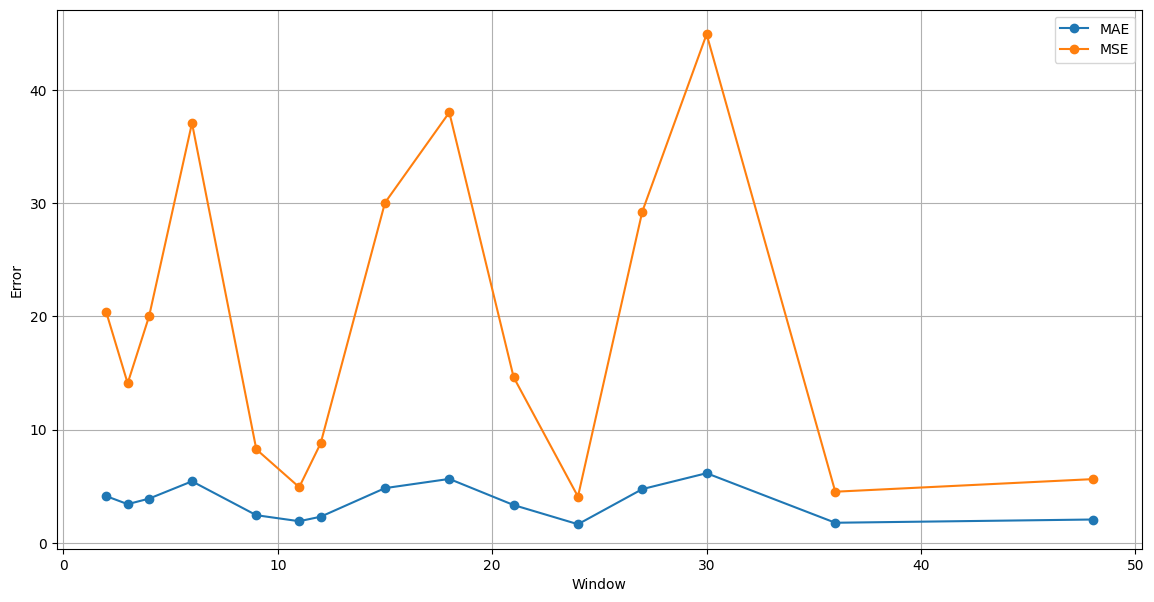

In [64]:
plt.figure(figsize=(14,7))
plt.plot(w, mae, marker='o')
plt.plot(w, mse, marker='o')
plt.legend(['MAE','MSE'])
plt.xlabel('Window')
plt.ylabel('Error')
plt.grid(True)
plt.show()

Quando aluentamos a janela tanto o erro MAE quanto o MSE tendem a aumentar, porém observamos que os multiplo de 12 possuem o erro menor que pode ser explicado devido a sazonalidade dos dados.

#### 4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.

In [40]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [41]:
prev = 12

In [42]:
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')

In [43]:
train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]
    
test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [47]:
lr = 0.005
epochs = 1000
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 128

In [45]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='relu',lr = lr)
    
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    
batch_size = 32
    
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [46]:
train(model, train_loader, epochs, device, lr)
y_result = multi_step(model, X_test, cod='numeric')

  9%|▉         | 90/1000 [00:00<00:03, 290.03it/s]

Epoch 51/1000, Loss: 0.0146
Epoch 101/1000, Loss: 0.0120


 18%|█▊        | 183/1000 [00:00<00:02, 302.18it/s]

Epoch 151/1000, Loss: 0.0117
Epoch 201/1000, Loss: 0.0115


 30%|███       | 305/1000 [00:01<00:02, 298.28it/s]

Epoch 251/1000, Loss: 0.0114
Epoch 301/1000, Loss: 0.0113


 40%|███▉      | 396/1000 [00:01<00:02, 289.80it/s]

Epoch 351/1000, Loss: 0.0111
Epoch 401/1000, Loss: 0.0110


 49%|████▉     | 489/1000 [00:01<00:01, 304.06it/s]

Epoch 451/1000, Loss: 0.0109
Epoch 501/1000, Loss: 0.0107


 58%|█████▊    | 582/1000 [00:01<00:01, 297.81it/s]

Epoch 551/1000, Loss: 0.0106
Epoch 601/1000, Loss: 0.0105


 71%|███████   | 706/1000 [00:02<00:01, 291.19it/s]

Epoch 651/1000, Loss: 0.0104
Epoch 701/1000, Loss: 0.0103


 80%|███████▉  | 797/1000 [00:02<00:00, 274.28it/s]

Epoch 751/1000, Loss: 0.0102
Epoch 801/1000, Loss: 0.0101


 88%|████████▊ | 884/1000 [00:03<00:00, 275.11it/s]

Epoch 851/1000, Loss: 0.0101
Epoch 901/1000, Loss: 0.0100


100%|██████████| 1000/1000 [00:03<00:00, 290.24it/s]

Epoch 951/1000, Loss: 0.0099
Epoch 1001/1000, Loss: 0.0098


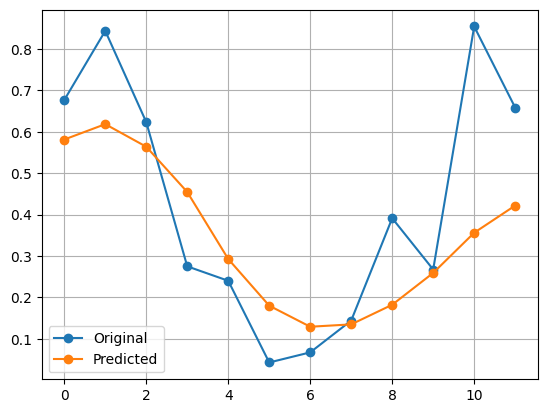

In [48]:
plt.plot(y_test, marker='o')
plt.plot(y_result,marker='o')

plt.legend(['Original','Predicted'])
plt.grid()
plt.show()

#### 5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado. 

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

In [49]:
def multi_step_binary(model, X_test, cod='binary'):
  y_result = []
  X_t = np.copy(X_test[0])

  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[4] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[4] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())

  return np.array(y_result)

In [50]:
prev = 12

In [51]:
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')

In [52]:
train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]
    
test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [60]:
lr = 0.005
epochs = 10000
n_input = X_train.shape[1]
n_output = 1
hidden_neurons =64   #sigmoid



In [61]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='relu',lr = lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    
batch_size = 32
    
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [62]:
train(model, train_loader, epochs, device, lr)
y_result = multi_step_binary(model, X_test, cod='binary')


  1%|          | 96/10000 [00:00<00:32, 307.73it/s]

Epoch 51/10000, Loss: 0.0277
Epoch 101/10000, Loss: 0.0176


  2%|▏         | 189/10000 [00:00<00:32, 301.59it/s]

Epoch 151/10000, Loss: 0.0135
Epoch 201/10000, Loss: 0.0119


  3%|▎         | 282/10000 [00:00<00:32, 299.56it/s]

Epoch 251/10000, Loss: 0.0112
Epoch 301/10000, Loss: 0.0108


  4%|▍         | 402/10000 [00:01<00:32, 291.14it/s]

Epoch 351/10000, Loss: 0.0106
Epoch 401/10000, Loss: 0.0104


  5%|▍         | 493/10000 [00:01<00:32, 290.86it/s]

Epoch 451/10000, Loss: 0.0102
Epoch 501/10000, Loss: 0.0100


  6%|▌         | 585/10000 [00:01<00:31, 294.79it/s]

Epoch 551/10000, Loss: 0.0098
Epoch 601/10000, Loss: 0.0097


  7%|▋         | 676/10000 [00:02<00:31, 296.24it/s]

Epoch 651/10000, Loss: 0.0096
Epoch 701/10000, Loss: 0.0094


  8%|▊         | 796/10000 [00:02<00:31, 290.62it/s]

Epoch 751/10000, Loss: 0.0093
Epoch 801/10000, Loss: 0.0092


  9%|▉         | 886/10000 [00:03<00:31, 288.41it/s]

Epoch 851/10000, Loss: 0.0091
Epoch 901/10000, Loss: 0.0090


 10%|█         | 1009/10000 [00:03<00:30, 297.35it/s]

Epoch 951/10000, Loss: 0.0089
Epoch 1001/10000, Loss: 0.0088


 11%|█         | 1100/10000 [00:03<00:30, 295.54it/s]

Epoch 1051/10000, Loss: 0.0088
Epoch 1101/10000, Loss: 0.0087


 12%|█▏        | 1190/10000 [00:04<00:30, 292.12it/s]

Epoch 1151/10000, Loss: 0.0086
Epoch 1201/10000, Loss: 0.0085


 13%|█▎        | 1310/10000 [00:04<00:30, 288.82it/s]

Epoch 1251/10000, Loss: 0.0085
Epoch 1301/10000, Loss: 0.0084


 14%|█▍        | 1401/10000 [00:04<00:28, 297.38it/s]

Epoch 1351/10000, Loss: 0.0084
Epoch 1401/10000, Loss: 0.0083


 15%|█▍        | 1492/10000 [00:05<00:29, 288.42it/s]

Epoch 1451/10000, Loss: 0.0082
Epoch 1501/10000, Loss: 0.0082


 16%|█▌        | 1584/10000 [00:05<00:28, 294.78it/s]

Epoch 1551/10000, Loss: 0.0081
Epoch 1601/10000, Loss: 0.0081


 17%|█▋        | 1706/10000 [00:05<00:27, 300.10it/s]

Epoch 1651/10000, Loss: 0.0080
Epoch 1701/10000, Loss: 0.0080


 18%|█▊        | 1799/10000 [00:06<00:27, 296.15it/s]

Epoch 1751/10000, Loss: 0.0079
Epoch 1801/10000, Loss: 0.0079


 19%|█▉        | 1887/10000 [00:06<00:30, 268.45it/s]

Epoch 1851/10000, Loss: 0.0078
Epoch 1901/10000, Loss: 0.0078


 20%|██        | 2010/10000 [00:06<00:27, 295.15it/s]

Epoch 1951/10000, Loss: 0.0077
Epoch 2001/10000, Loss: 0.0077


 21%|██        | 2102/10000 [00:07<00:26, 299.24it/s]

Epoch 2051/10000, Loss: 0.0076
Epoch 2101/10000, Loss: 0.0076


 22%|██▏       | 2195/10000 [00:07<00:25, 301.85it/s]

Epoch 2151/10000, Loss: 0.0076
Epoch 2201/10000, Loss: 0.0075


 23%|██▎       | 2286/10000 [00:07<00:26, 289.01it/s]

Epoch 2251/10000, Loss: 0.0075
Epoch 2301/10000, Loss: 0.0075


 24%|██▍       | 2408/10000 [00:08<00:25, 302.14it/s]

Epoch 2351/10000, Loss: 0.0075
Epoch 2401/10000, Loss: 0.0074


 25%|██▌       | 2503/10000 [00:08<00:24, 304.18it/s]

Epoch 2451/10000, Loss: 0.0074
Epoch 2501/10000, Loss: 0.0074


 26%|██▌       | 2597/10000 [00:08<00:26, 284.11it/s]

Epoch 2551/10000, Loss: 0.0073
Epoch 2601/10000, Loss: 0.0073


 27%|██▋       | 2677/10000 [00:09<00:32, 226.87it/s]

Epoch 2651/10000, Loss: 0.0073


 27%|██▋       | 2723/10000 [00:09<00:34, 213.79it/s]

Epoch 2701/10000, Loss: 0.0073


 28%|██▊       | 2790/10000 [00:09<00:33, 213.92it/s]

Epoch 2751/10000, Loss: 0.0072


 28%|██▊       | 2834/10000 [00:10<00:34, 208.14it/s]

Epoch 2801/10000, Loss: 0.0072


 29%|██▉       | 2878/10000 [00:10<00:33, 212.64it/s]

Epoch 2851/10000, Loss: 0.0072


 29%|██▉       | 2921/10000 [00:10<00:33, 209.32it/s]

Epoch 2901/10000, Loss: 0.0072


 30%|██▉       | 2988/10000 [00:10<00:32, 214.98it/s]

Epoch 2951/10000, Loss: 0.0071


 30%|███       | 3032/10000 [00:10<00:32, 215.93it/s]

Epoch 3001/10000, Loss: 0.0071


 31%|███       | 3076/10000 [00:11<00:32, 210.47it/s]

Epoch 3051/10000, Loss: 0.0071


 31%|███▏      | 3140/10000 [00:11<00:34, 201.67it/s]

Epoch 3101/10000, Loss: 0.0071


 32%|███▏      | 3181/10000 [00:11<00:34, 196.79it/s]

Epoch 3151/10000, Loss: 0.0070


 32%|███▏      | 3232/10000 [00:11<00:30, 224.41it/s]

Epoch 3201/10000, Loss: 0.0070
Epoch 3251/10000, Loss: 0.0070


 34%|███▎      | 3352/10000 [00:12<00:23, 279.03it/s]

Epoch 3301/10000, Loss: 0.0070
Epoch 3351/10000, Loss: 0.0069


 34%|███▍      | 3444/10000 [00:12<00:22, 291.22it/s]

Epoch 3401/10000, Loss: 0.0069
Epoch 3451/10000, Loss: 0.0069


 35%|███▌      | 3536/10000 [00:12<00:21, 294.39it/s]

Epoch 3501/10000, Loss: 0.0069
Epoch 3551/10000, Loss: 0.0068


 37%|███▋      | 3657/10000 [00:13<00:21, 290.03it/s]

Epoch 3601/10000, Loss: 0.0068
Epoch 3651/10000, Loss: 0.0068


 37%|███▋      | 3748/10000 [00:13<00:21, 294.57it/s]

Epoch 3701/10000, Loss: 0.0068
Epoch 3751/10000, Loss: 0.0067


 38%|███▊      | 3842/10000 [00:14<00:20, 303.81it/s]

Epoch 3801/10000, Loss: 0.0067
Epoch 3851/10000, Loss: 0.0067


 39%|███▉      | 3935/10000 [00:14<00:20, 297.15it/s]

Epoch 3901/10000, Loss: 0.0067
Epoch 3951/10000, Loss: 0.0067


 41%|████      | 4053/10000 [00:14<00:21, 277.76it/s]

Epoch 4001/10000, Loss: 0.0066
Epoch 4051/10000, Loss: 0.0066


 41%|████▏     | 4145/10000 [00:15<00:19, 293.37it/s]

Epoch 4101/10000, Loss: 0.0066
Epoch 4151/10000, Loss: 0.0066


 42%|████▏     | 4239/10000 [00:15<00:18, 303.72it/s]

Epoch 4201/10000, Loss: 0.0066
Epoch 4251/10000, Loss: 0.0066


 43%|████▎     | 4330/10000 [00:15<00:21, 265.76it/s]

Epoch 4301/10000, Loss: 0.0065


 44%|████▍     | 4381/10000 [00:15<00:25, 223.86it/s]

Epoch 4351/10000, Loss: 0.0065


 44%|████▍     | 4426/10000 [00:16<00:26, 209.08it/s]

Epoch 4401/10000, Loss: 0.0065


 45%|████▍     | 4492/10000 [00:16<00:26, 210.92it/s]

Epoch 4451/10000, Loss: 0.0065


 45%|████▌     | 4536/10000 [00:16<00:26, 209.22it/s]

Epoch 4501/10000, Loss: 0.0065


 46%|████▌     | 4580/10000 [00:16<00:26, 207.94it/s]

Epoch 4551/10000, Loss: 0.0065


 46%|████▌     | 4622/10000 [00:17<00:26, 205.17it/s]

Epoch 4601/10000, Loss: 0.0064


 47%|████▋     | 4687/10000 [00:17<00:25, 204.75it/s]

Epoch 4651/10000, Loss: 0.0064


 47%|████▋     | 4729/10000 [00:17<00:25, 205.00it/s]

Epoch 4701/10000, Loss: 0.0064


 48%|████▊     | 4772/10000 [00:17<00:25, 205.70it/s]

Epoch 4751/10000, Loss: 0.0064


 48%|████▊     | 4836/10000 [00:18<00:25, 204.52it/s]

Epoch 4801/10000, Loss: 0.0064


 49%|████▉     | 4877/10000 [00:18<00:25, 197.10it/s]

Epoch 4851/10000, Loss: 0.0064


 49%|████▉     | 4946/10000 [00:18<00:22, 220.55it/s]

Epoch 4901/10000, Loss: 0.0064


 50%|█████     | 5007/10000 [00:18<00:19, 260.44it/s]

Epoch 4951/10000, Loss: 0.0063
Epoch 5001/10000, Loss: 0.0063


 51%|█████     | 5099/10000 [00:19<00:17, 286.97it/s]

Epoch 5051/10000, Loss: 0.0063
Epoch 5101/10000, Loss: 0.0063


 52%|█████▏    | 5192/10000 [00:19<00:16, 297.93it/s]

Epoch 5151/10000, Loss: 0.0063
Epoch 5201/10000, Loss: 0.0063


 53%|█████▎    | 5284/10000 [00:19<00:16, 291.82it/s]

Epoch 5251/10000, Loss: 0.0063
Epoch 5301/10000, Loss: 0.0062


 54%|█████▍    | 5411/10000 [00:20<00:14, 306.85it/s]

Epoch 5351/10000, Loss: 0.0062
Epoch 5401/10000, Loss: 0.0062


 55%|█████▌    | 5504/10000 [00:20<00:14, 301.16it/s]

Epoch 5451/10000, Loss: 0.0062
Epoch 5501/10000, Loss: 0.0062


 56%|█████▌    | 5598/10000 [00:20<00:15, 287.42it/s]

Epoch 5551/10000, Loss: 0.0062
Epoch 5601/10000, Loss: 0.0062


 57%|█████▋    | 5690/10000 [00:21<00:14, 293.32it/s]

Epoch 5651/10000, Loss: 0.0062
Epoch 5701/10000, Loss: 0.0062


 58%|█████▊    | 5783/10000 [00:21<00:14, 295.60it/s]

Epoch 5751/10000, Loss: 0.0061
Epoch 5801/10000, Loss: 0.0061


 59%|█████▊    | 5874/10000 [00:21<00:14, 276.33it/s]

Epoch 5851/10000, Loss: 0.0061


 59%|█████▉    | 5928/10000 [00:22<00:17, 232.24it/s]

Epoch 5901/10000, Loss: 0.0061


 60%|█████▉    | 5975/10000 [00:22<00:18, 219.37it/s]

Epoch 5951/10000, Loss: 0.0061


 60%|██████    | 6041/10000 [00:22<00:19, 203.36it/s]

Epoch 6001/10000, Loss: 0.0061


 61%|██████    | 6084/10000 [00:23<00:19, 200.20it/s]

Epoch 6051/10000, Loss: 0.0061


 61%|██████▏   | 6127/10000 [00:23<00:18, 204.52it/s]

Epoch 6101/10000, Loss: 0.0061


 62%|██████▏   | 6192/10000 [00:23<00:18, 209.78it/s]

Epoch 6151/10000, Loss: 0.0061


 62%|██████▏   | 6235/10000 [00:23<00:18, 209.16it/s]

Epoch 6201/10000, Loss: 0.0060


 63%|██████▎   | 6277/10000 [00:23<00:18, 199.01it/s]

Epoch 6251/10000, Loss: 0.0060


 63%|██████▎   | 6340/10000 [00:24<00:18, 199.03it/s]

Epoch 6301/10000, Loss: 0.0060


 64%|██████▍   | 6379/10000 [00:24<00:20, 178.57it/s]

Epoch 6351/10000, Loss: 0.0060


 64%|██████▍   | 6422/10000 [00:24<00:18, 192.93it/s]

Epoch 6401/10000, Loss: 0.0060


 65%|██████▌   | 6502/10000 [00:25<00:14, 243.04it/s]

Epoch 6451/10000, Loss: 0.0060
Epoch 6501/10000, Loss: 0.0060


 66%|██████▌   | 6596/10000 [00:25<00:11, 284.35it/s]

Epoch 6551/10000, Loss: 0.0060
Epoch 6601/10000, Loss: 0.0060


 67%|██████▋   | 6689/10000 [00:25<00:11, 297.05it/s]

Epoch 6651/10000, Loss: 0.0060
Epoch 6701/10000, Loss: 0.0059


 68%|██████▊   | 6807/10000 [00:26<00:11, 279.79it/s]

Epoch 6751/10000, Loss: 0.0059
Epoch 6801/10000, Loss: 0.0059


 69%|██████▉   | 6898/10000 [00:26<00:10, 295.00it/s]

Epoch 6851/10000, Loss: 0.0059
Epoch 6901/10000, Loss: 0.0059


 70%|██████▉   | 6991/10000 [00:26<00:10, 298.97it/s]

Epoch 6951/10000, Loss: 0.0059
Epoch 7001/10000, Loss: 0.0059


 71%|███████   | 7082/10000 [00:27<00:10, 289.90it/s]

Epoch 7051/10000, Loss: 0.0059
Epoch 7101/10000, Loss: 0.0059


 72%|███████▏  | 7205/10000 [00:27<00:09, 294.70it/s]

Epoch 7151/10000, Loss: 0.0059
Epoch 7201/10000, Loss: 0.0058


 73%|███████▎  | 7298/10000 [00:27<00:08, 300.62it/s]

Epoch 7251/10000, Loss: 0.0058
Epoch 7301/10000, Loss: 0.0058


 74%|███████▍  | 7391/10000 [00:28<00:08, 293.70it/s]

Epoch 7351/10000, Loss: 0.0058
Epoch 7401/10000, Loss: 0.0058


 75%|███████▍  | 7484/10000 [00:28<00:08, 302.35it/s]

Epoch 7451/10000, Loss: 0.0058
Epoch 7501/10000, Loss: 0.0058


 76%|███████▌  | 7607/10000 [00:28<00:08, 293.61it/s]

Epoch 7551/10000, Loss: 0.0058
Epoch 7601/10000, Loss: 0.0058


 77%|███████▋  | 7701/10000 [00:29<00:07, 295.74it/s]

Epoch 7651/10000, Loss: 0.0058
Epoch 7701/10000, Loss: 0.0058


 78%|███████▊  | 7793/10000 [00:29<00:07, 301.26it/s]

Epoch 7751/10000, Loss: 0.0057
Epoch 7801/10000, Loss: 0.0057


 79%|███████▉  | 7886/10000 [00:29<00:07, 299.78it/s]

Epoch 7851/10000, Loss: 0.0057
Epoch 7901/10000, Loss: 0.0057


 80%|████████  | 8011/10000 [00:30<00:06, 300.27it/s]

Epoch 7951/10000, Loss: 0.0057
Epoch 8001/10000, Loss: 0.0057


 81%|████████  | 8105/10000 [00:30<00:06, 302.00it/s]

Epoch 8051/10000, Loss: 0.0057
Epoch 8101/10000, Loss: 0.0057


 82%|████████▏ | 8198/10000 [00:30<00:06, 299.75it/s]

Epoch 8151/10000, Loss: 0.0057
Epoch 8201/10000, Loss: 0.0057


 83%|████████▎ | 8293/10000 [00:31<00:05, 308.54it/s]

Epoch 8251/10000, Loss: 0.0057
Epoch 8301/10000, Loss: 0.0056


 84%|████████▍ | 8388/10000 [00:31<00:05, 302.75it/s]

Epoch 8351/10000, Loss: 0.0056
Epoch 8401/10000, Loss: 0.0056


 85%|████████▌ | 8513/10000 [00:31<00:04, 307.13it/s]

Epoch 8451/10000, Loss: 0.0056
Epoch 8501/10000, Loss: 0.0056


 86%|████████▌ | 8606/10000 [00:32<00:04, 294.52it/s]

Epoch 8551/10000, Loss: 0.0056
Epoch 8601/10000, Loss: 0.0056


 87%|████████▋ | 8698/10000 [00:32<00:04, 294.62it/s]

Epoch 8651/10000, Loss: 0.0056
Epoch 8701/10000, Loss: 0.0056


 88%|████████▊ | 8789/10000 [00:32<00:04, 295.52it/s]

Epoch 8751/10000, Loss: 0.0056
Epoch 8801/10000, Loss: 0.0056


 89%|████████▉ | 8883/10000 [00:33<00:03, 300.53it/s]

Epoch 8851/10000, Loss: 0.0056
Epoch 8901/10000, Loss: 0.0055


 90%|█████████ | 9006/10000 [00:33<00:03, 296.10it/s]

Epoch 8951/10000, Loss: 0.0055
Epoch 9001/10000, Loss: 0.0055


 91%|█████████ | 9098/10000 [00:33<00:03, 298.97it/s]

Epoch 9051/10000, Loss: 0.0055
Epoch 9101/10000, Loss: 0.0055


 92%|█████████▏| 9191/10000 [00:34<00:02, 300.26it/s]

Epoch 9151/10000, Loss: 0.0055
Epoch 9201/10000, Loss: 0.0055


 93%|█████████▎| 9287/10000 [00:34<00:02, 305.46it/s]

Epoch 9251/10000, Loss: 0.0055
Epoch 9301/10000, Loss: 0.0055


 94%|█████████▍| 9381/10000 [00:34<00:02, 305.23it/s]

Epoch 9351/10000, Loss: 0.0055
Epoch 9401/10000, Loss: 0.0055


 95%|█████████▍| 9470/10000 [00:35<00:02, 246.86it/s]

Epoch 9451/10000, Loss: 0.0054


 95%|█████████▌| 9543/10000 [00:35<00:02, 224.39it/s]

Epoch 9501/10000, Loss: 0.0054


 96%|█████████▌| 9587/10000 [00:35<00:02, 201.90it/s]

Epoch 9551/10000, Loss: 0.0054


 96%|█████████▋| 9630/10000 [00:35<00:01, 204.79it/s]

Epoch 9601/10000, Loss: 0.0054


 97%|█████████▋| 9672/10000 [00:36<00:01, 203.18it/s]

Epoch 9651/10000, Loss: 0.0054


 97%|█████████▋| 9737/10000 [00:36<00:01, 206.42it/s]

Epoch 9701/10000, Loss: 0.0054


 98%|█████████▊| 9782/10000 [00:36<00:01, 212.77it/s]

Epoch 9751/10000, Loss: 0.0054


 98%|█████████▊| 9827/10000 [00:36<00:00, 217.28it/s]

Epoch 9801/10000, Loss: 0.0054


 99%|█████████▊| 9871/10000 [00:37<00:00, 207.65it/s]

Epoch 9851/10000, Loss: 0.0054


 99%|█████████▉| 9936/10000 [00:37<00:00, 200.81it/s]

Epoch 9901/10000, Loss: 0.0053


100%|█████████▉| 9979/10000 [00:37<00:00, 205.29it/s]

Epoch 9951/10000, Loss: 0.0053


100%|██████████| 10000/10000 [00:37<00:00, 265.04it/s]

Epoch 10001/10000, Loss: 0.0053


In [65]:
from sklearn.metrics import r2_score

Erro MSE = 6.071 
Erro MAE = 1.945  
R2 Score = 0.634


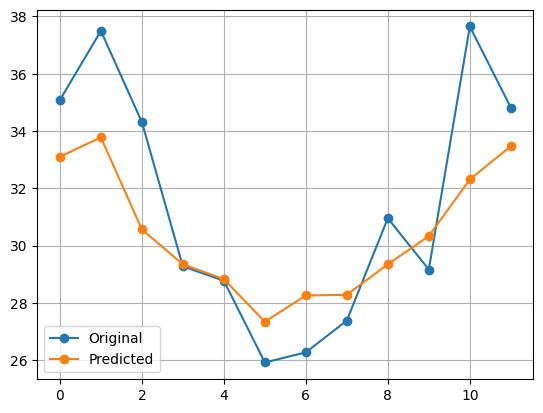

In [67]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min

mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)  #(Mean Absoluto Error)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)   #(Mean Squared Error)
r2_error = r2_score(orig_y_eval, orig_y_hat)              #(R dois score)

plt.plot(orig_y_eval,marker='o')
plt.plot(orig_y_hat,marker='o')
plt.legend(['Original','Predicted'])
plt.grid()


print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}  \nR2 Score = {round(r2_error,3)}')